In [1]:
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
def hermite(x, n):
    """
    hermite polynomials of order n
    defined on the real space x

    Parameters
    ----------
    x : np.ndarray
        Real space
    n : int
        order of the polynomial

    Returns
    -------
    np.ndarray
        Hermite polynomial of order n
    """
    herm_coeffs = np.zeros(n+1)
    herm_coeffs[n] = 1
    return np.polynomial.hermite.hermval(x, herm_coeffs)

def stationary_state(x,n):
    """
    Returns the stationary state of order
    n of the quantum harmonic oscillator

    Parameters
    ----------
    x : np.ndarray
        Real space
    n : int
        order of the stationary state. 0 is ground state.

    Returns
    -------
    np.ndarray
        Stationary state of order n
    """
    prefactor = 1./np.sqrt(2.**n * factorial(n)) * (1/(np.pi))**(0.25)
    psi = prefactor * np.exp(- x**2 / 2) * hermite(x,n)
    return psi

In [3]:
class Param:
    """
    Container for holding all simulation parameters

    Parameters
    ----------
    xmax : float
        The real space is between [-xmax, xmax]
    num_x : int
        Number of intervals in [-xmax, xmax]
    dt : float
        Time discretization
    timesteps : int
        Number of timestep
    im_time : bool, optional
        If True, use imaginary time evolution.
        Default to False.
    """
    def __init__(self,
                 xmax: float,
                 num_x: int,
                 dt: float,
                 timesteps: int,
                 im_time: bool = False) -> None:

        self.xmax = xmax
        self.num_x = num_x
        self.dt = dt
        self.timesteps = timesteps
        self.im_time = im_time

        self.dx = 2 * xmax / num_x
        # Real time grid
        self.x = np.arange(-xmax + xmax / num_x, xmax, self.dx)
        # Definition of the momentum
        self.dk = np.pi / xmax
        # Momentum grid -> DONE FOR THE FFT, which wants the frequencies in this order!!!
        self.k = np.concatenate((np.arange(0, num_x / 2), np.arange(-num_x / 2, 0))) * self.dk

class Operators:
    """Container for holding operators and wavefunction coefficients."""
    def __init__(self, res: int) -> None:

        self.V = np.empty(res, dtype=complex)
        self.R = np.empty(res, dtype=complex)
        self.K = np.empty(res, dtype=complex)
        self.wfc = np.empty(res, dtype=complex)

In [4]:
def init(par: Param, voffset: float, wfcoffset: float, n: int = 0, q0_func=None) -> Operators:
    """
    Initialize the wavefunction coefficients and the potential with a time-dependent offset.

    Parameters
    ----------
    par: Param
        Class containing the parameters of the simulation
    voffset : float, optional
        Offset of the quadratic potential in real space
        Default to 0.
    wfcoffset: float, optional
        Offset of the wavefunction in real space. Default to 0.
    n : int, optional
        Order of the hermite polynomial (i.e. level of eigenstate)
    q0_func : callable, optional
        A function q0_func(t) defining the time-dependent offset q0(t). Default is None.

    Returns
    -------
    Operators
        Filled operators
    """
    opr = Operators(len(par.x))

    # Define the time-dependent offset function q0(t)
    if q0_func is None:
        q0_func = lambda t: 0  # Default to no offset if not provided

    # Quadratic potential with offset (initially at t=0)
    q0 = q0_func(0)
    opr.V = 0.5 * (par.x - voffset - q0) ** 2
    opr.wfc = stationary_state(par.x - wfcoffset, n).astype(complex)

    # Coefficient for imaginary/real time evolution
    coeff = 1 if par.im_time else 1j

    # Operator in momentum space -> potential
    opr.K = np.exp(-0.5 * (par.k ** 2) * par.dt * coeff)
    # Operator in real space -> kinetic
    opr.R = np.exp(-0.5 * opr.V * par.dt * coeff)

    opr.q0_func = q0_func  # Save the offset function for later use
    return opr


In [51]:
def split_op(par: Param, opr: Operators) -> None:
    """
    Split operator method for time evolution.
    Works in place

    Parameters
    ----------
    par : Param
        Parameters of the simulation
    opr : Operators
        Operators of the simulation

    Returns
    -------
    None
        Acts in place
    """
    # Store the results in res.
    # Use the first 100 to store the wfc in real
    # space and the other half to store the wavefunction
    # in momentum space
    res = np.zeros((100, 2 * par.num_x))
    potential = np.zeros((100, par.num_x))  # Store the potential at each timestep
    jj = 0
    for i in range(par.timesteps):

        # Compute the time-dependent potential V(x, t)
        q0 = opr.q0_func(i * par.dt)  # Time-dependent offset
        opr.V = 0.5 * (par.x - q0) ** 2  # Update potential with time-dependent offset
        opr.R = np.exp(-0.5 * opr.V * par.dt * (1 if par.im_time else 1j))

        # Half-step in real space
        opr.wfc *= opr.R

        # FFT to momentum space
        opr.wfc = np.fft.fft(opr.wfc)

        # Full step in momentum space
        opr.wfc *= opr.K

        # iFFT back
        opr.wfc = np.fft.ifft(opr.wfc)

        # Final half-step in real space
        opr.wfc *= opr.R

        # Density for plotting and potential
        density = np.abs(opr.wfc) ** 2

        if par.im_time:
          renorm_factor = np.sum(density * par.dx)
          if renorm_factor != 0.0:
            opr.wfc /= np.sqrt(renorm_factor)
          else:
            print(f"Renorm factor too small at timestep {i}: {renorm_factor}")

        # This is set to save exactly 100 snapshots, no
        # matter how many timesteps were specified.
        if i % (par.timesteps // 100) == 0 and jj < 100:
            res[jj, 0:par.num_x] = np.real(density)
            res[jj, par.num_x:2 * par.num_x] = np.abs(np.fft.fft(opr.wfc)) ** 2
            potential[jj, :] = opr.V  # Store the updated potential
            jj += 1

    return res, potential


In [52]:
def calculate_energy(par: Param, opr: Operators) -> float:
    """Calculate the energy <Psi|H|Psi>."""
    # Creating real, momentum, and conjugate wavefunctions.
    wfc_r = opr.wfc
    wfc_k = np.fft.fft(wfc_r)
    wfc_c = np.conj(wfc_r)

    # Finding the momentum and real-space energy terms
    energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
    energy_r = wfc_c * opr.V * wfc_r

    # Integrating over all space
    energy_final = sum(energy_k + energy_r).real

    return energy_final * par.dx

In [53]:
# Example: q0(t) = A * np.sin(omega * t)
A = 1.0  # Amplitude of oscillation
omega = 2.0  # Frequency of oscillation

q0_func = lambda t: A * np.sin(omega * t)

# Initialize the simulation
par = Param(xmax=10.0, num_x=512, dt=0.01, timesteps=1000, im_time=True)
opr = init(par, voffset=0.0, wfcoffset=0.0, n=10, q0_func=q0_func)

# Run the simulation
res, potential = split_op(par, opr)

In [54]:
print(f"The final energy of your systems is: {calculate_energy(par, opr)}")

The final energy of your systems is: 0.8937577376006545


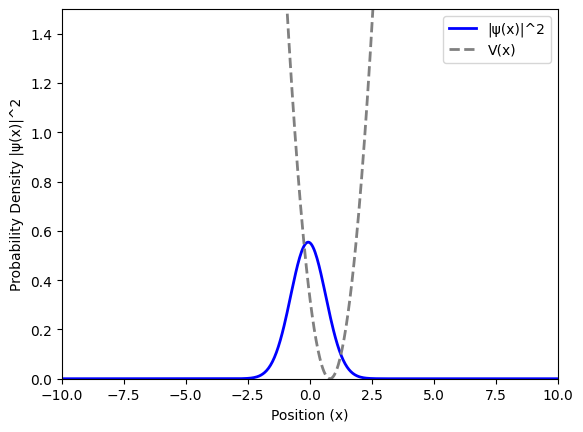

In [55]:
# Set up the figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-par.xmax, par.xmax)
ax.set_ylim(0, 1.5)
ax.set_xlabel("Position (x)")
ax.set_ylabel("Probability Density |ψ(x)|^2")

# Lines for the wave function and potential
line_wfc, = ax.plot([], [], lw=2, label="|ψ(x)|^2", color='blue')
line_pot, = ax.plot([], [], lw=2, label="V(x)", color='gray', linestyle='--')
ax.legend()

# Initialization function for the animation
def init_line():
    line_wfc.set_data([], [])
    line_pot.set_data([], [])
    return line_wfc, line_pot

# Animation function to update the plot at each frame
def animate(i):
    x = par.x
    y_wfc = res[i, :par.num_x]  # Extract density from res for frame i
    y_pot = potential[i, :]  # Extract potential from the stored potential array

    # Set data for the lines
    line_wfc.set_data(x, y_wfc)
    line_pot.set_data(x, y_pot)
    return line_wfc, line_pot

# Create the animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init_line, frames=100, interval=20, blit=True
)

# Save the animation as a GIF
writer = animation.PillowWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
anim.save('real_space_with_moving_potential.gif', writer=writer)


In [63]:
def split_op(par: Param, opr: Operators) -> None:
    """
    Split operator method for time evolution.
    Works in place

    Parameters
    ----------
    par : Param
        Parameters of the simulation
    opr : Operators
        Operators of the simulation

    Returns
    -------
    None
        Acts in place
    """
    # Store the results in res.
    res = np.zeros((100, 2 * par.num_x))
    potential = np.zeros((100, par.num_x))  # Store the potential at each timestep
    avg_position = np.zeros(100)  # Array to store the average position at each timestep
    jj = 0

    for i in range(par.timesteps):

        # Compute the time-dependent potential V(x, t)
        q0 = opr.q0_func(i * par.dt)  # Time-dependent offset
        opr.V = 0.5 * (par.x - q0) ** 2  # Update potential with time-dependent offset
        opr.R = np.exp(-0.5 * opr.V * par.dt * (1 if par.im_time else 1j))
        
        # Half-step in real space
        opr.wfc *= opr.R

        # FFT to momentum space
        opr.wfc = np.fft.fft(opr.wfc)

        # Full step in momentum space
        opr.wfc *= opr.K

        # iFFT back
        opr.wfc = np.fft.ifft(opr.wfc)

        # Final half-step in real space
        opr.wfc *= opr.R

        # Density for plotting and potential
        density = np.abs(opr.wfc) ** 2

        # Renormalizing for imaginary time
        if par.im_time:
          renorm_factor = np.sum(density * par.dx)
          if renorm_factor != 0.0:
            opr.wfc /= np.sqrt(renorm_factor)
          else:
            print(f"Renorm factor too small at timestep {i}: {renorm_factor}")

        # Save snapshots of the wavefunction and potential
        if i % (par.timesteps // 100) == 0 and jj < 100:
            res[jj, 0:par.num_x] = np.real(density)
            res[jj, par.num_x:2 * par.num_x] = np.abs(np.fft.fft(opr.wfc)) ** 2
            potential[jj, :] = opr.V  # Store the updated potential
            avg_position[jj] = np.sum(par.x * density) * par.dx  # Sum over all grid points
            jj += 1

    return res, potential, avg_position

In [64]:
# Example: q0(t) = A * np.sin(omega * t)
A = 1.0  # Amplitude of oscillation
omega = 2.0  # Frequency of oscillation

q0_func = lambda t: A * np.sin(omega * t)

# Initialize the simulation
par = Param(xmax=10.0, num_x=512, dt=0.01, timesteps=1000, im_time=True)
opr = init(par, voffset=0.0, wfcoffset=0.0, n=10, q0_func=q0_func)

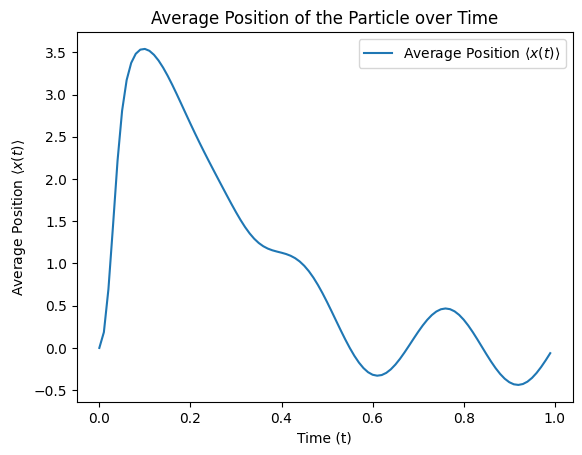

In [65]:
# Run the simulation and get the results
res, potential, avg_position = split_op(par, opr)

# Time array (you can calculate this from the number of timesteps and the timestep size)
time = np.arange(par.timesteps) * par.dt

# Plot the average position vs time
plt.figure()
plt.plot(time[:100], avg_position[:100], label="Average Position $\langle x(t) \\rangle$")
plt.xlabel("Time (t)")
plt.ylabel("Average Position $\langle x(t) \\rangle$")
plt.legend()
plt.title("Average Position of the Particle over Time")
plt.show()

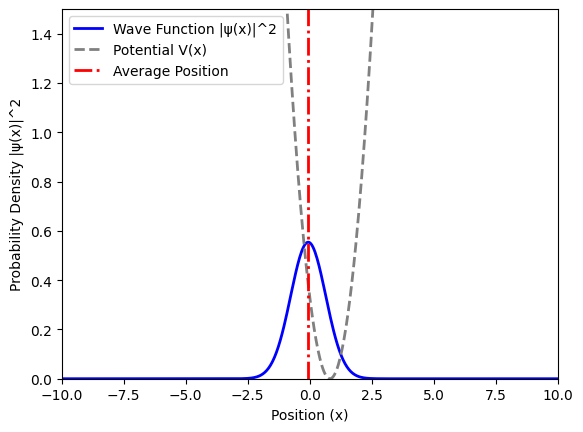

In [66]:
# Set up the figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-par.xmax, par.xmax)
ax.set_ylim(0, 1.5)
ax.set_xlabel("Position (x)")
ax.set_ylabel("Probability Density |ψ(x)|^2")

# Lines for the wave function, potential, and average position
line_wfc, = ax.plot([], [], lw=2, label="Wave Function |ψ(x)|^2", color='blue')
line_pot, = ax.plot([], [], lw=2, label="Potential V(x)", color='gray', linestyle='--')
line_avg_pos, = ax.plot([], [], lw=2, label="Average Position", color='red', linestyle='-.')

ax.legend()

# Initialization function for the animation
def init_line():
    line_wfc.set_data([], [])
    line_pot.set_data([], [])
    line_avg_pos.set_data([], [])
    return line_wfc, line_pot, line_avg_pos

# Animation function to update the plot at each frame
def animate(i):
    x = par.x
    y_wfc = res[i, :par.num_x]  # Extract density from res for frame i
    y_pot = potential[i, :]  # Extract potential from the stored potential array
    avg_pos = avg_position[i]  # Extract the average position for the current timestep

    # Set data for the wave function and potential
    line_wfc.set_data(x, y_wfc)
    line_pot.set_data(x, y_pot)

    # Update the average position line
    line_avg_pos.set_data([avg_pos, avg_pos], [0, 1.5])  # Vertical line from y=0 to y=1.5

    return line_wfc, line_pot, line_avg_pos

# Create the animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init_line, frames=100, interval=20, blit=True
)

# Save the animation as a GIF
writer = animation.PillowWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
anim.save('real_space_with_avg_position.gif', writer=writer)
